In [21]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Traffic Management system/traffic.csv')

In [3]:
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [4]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1nu2x92I3oCsUJq8Mu28-MMCJ_7m3KOhhRQHmNgdkOv0#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [5]:
print(df.isnull().sum())

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


In [6]:
print(df.duplicated().sum())

0


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None


In [8]:
# Converting junction and ID to categorical varibles
df['Junction'] = df['Junction'].astype('category')
df['ID'] = df['ID'].astype('category')

# Converting Datetime to dtype Datetime
df['Datetime'] = pd.to_datetime(df['DateTime'])
# Extracting Year, Month, Day and Hour from datetime
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour

# Exploratory Data Analysis

In [9]:
# Grouping data by junction
junction_data = df.groupby('Junction')['Vehicles'].sum().reset_index()

print(junction_data)

# Analyzing the vehicles by hour of the day
hourly_data = df.groupby('Hour')['Vehicles'].sum().reset_index()

print(hourly_data)

  Junction  Vehicles
0        1    657412
1        2    207983
2        3    199823
3        4     31501
    Hour  Vehicles
0      0     47199
1      1     39408
2      2     34291
3      3     29769
4      4     26011
5      5     24408
6      6     26025
7      7     29480
8      8     32888
9      9     38856
10    10     48581
11    11     55128
12    12     56950
13    13     51305
14    14     55544
15    15     55439
16    16     53482
17    17     53430
18    18     56331
19    19     59859
20    20     59799
21    21     56547
22    22     54590
23    23     51399


<ipython-input-9-52e6c71d1a10>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  junction_data = df.groupby('Junction')['Vehicles'].sum().reset_index()


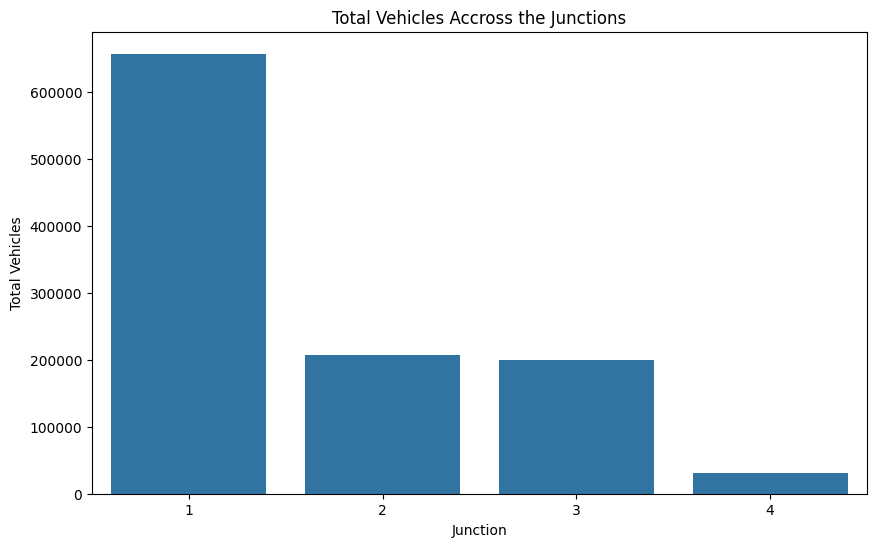

Text(0, 0.5, 'Total Vehicles')

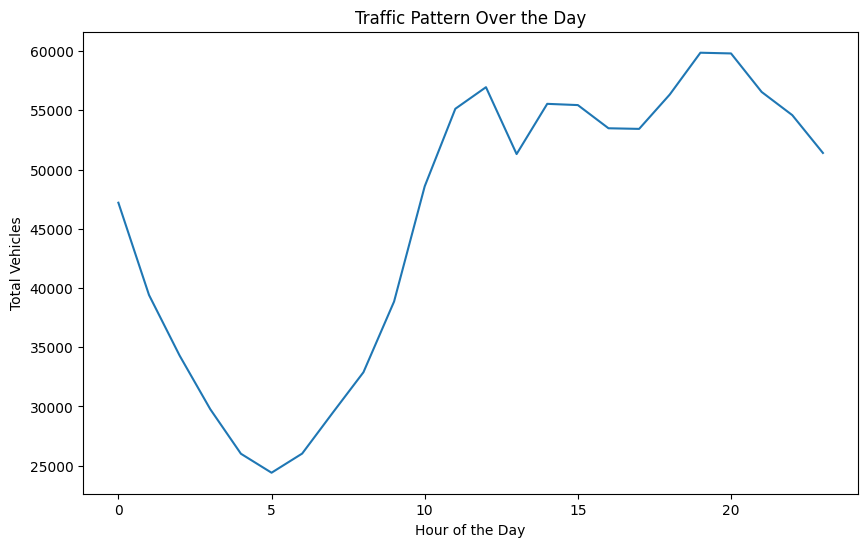

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting traffic accross junctions
plt.figure(figsize=(10,6))
sns.barplot(x='Junction', y='Vehicles', data=junction_data)
plt.title('Total Vehicles Accross the Junctions')
plt.xlabel('Junction')
plt.ylabel('Total Vehicles')
plt.show()

# Traffic Pattern over the day
plt.figure(figsize=(10,6))
sns.lineplot(x='Hour', y='Vehicles', data=hourly_data)
plt.title('Traffic Pattern Over the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Vehicles')

In [11]:
# Creating lag features to account for traffic in the previous hours
df['Vehicles_lag_1'] = df['Vehicles'].shift(1)
df['Vehicles_lag_2'] = df['Vehicles'].shift(2)
df[['Vehicles_lag_1', 'Vehicles_lag_2']] = df[['Vehicles_lag_1', 'Vehicles_lag_2']].fillna(0)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
X = df[['Junction', 'ID', 'Year', 'Month', 'Day', 'Hour', 'Vehicles_lag_1', 'Vehicles_lag_2']]
y = df['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 15.130444981296758


# Hyperparameter Tuning

In [13]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f'Best Parameters: {best_params}')
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
print(f'Mean Squared Error (Best Model): {mse_best}')

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Mean Squared Error (Best Model): 14.556881219613215


# Visualizing Multiple traffic Reduction at different junctions

<ipython-input-17-5ce8ab997b31>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  junction_data = df.groupby('Junction')['Vehicles'].sum().reset_index()


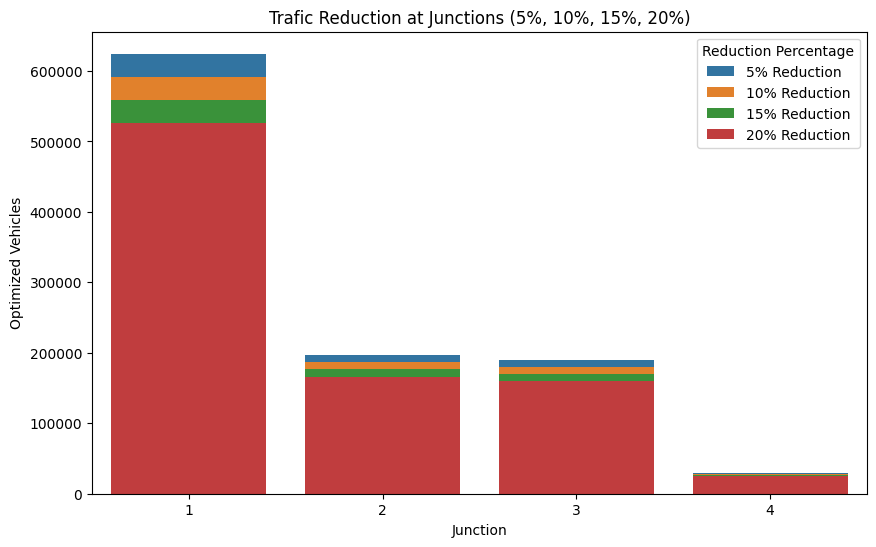

In [17]:
# Traffic Reduction Scenarios (5%, 10%, 15%, 20%)
reduction_scenarios = [0.05, 0.10, 0.15, 0.20]

# Computing vehicle reduction for each scenario
junction_data = df.groupby('Junction')['Vehicles'].sum().reset_index()
# Creating new columns for each reduction scenario
for reduction in reduction_scenarios:
  junction_data[f'Vehicles_Reduced_{int(reduction*100)}'] = junction_data['Vehicles'] * (1 - reduction)

# Visualizing Traffic reduction per junction for each scenario
plt.figure(figsize=(10,6))
for reduction in reduction_scenarios:
  sns.barplot(x = 'Junction', y = f'Vehicles_Reduced_{int(reduction*100)}', data = junction_data, label = f'{int(reduction*100)}% Reduction')
plt.title('Trafic Reduction at Junctions (5%, 10%, 15%, 20%)')
plt.xlabel('Junction')
plt.ylabel('Optimized Vehicles')
plt.legend(title = 'Reduction Percentage')
plt.show()




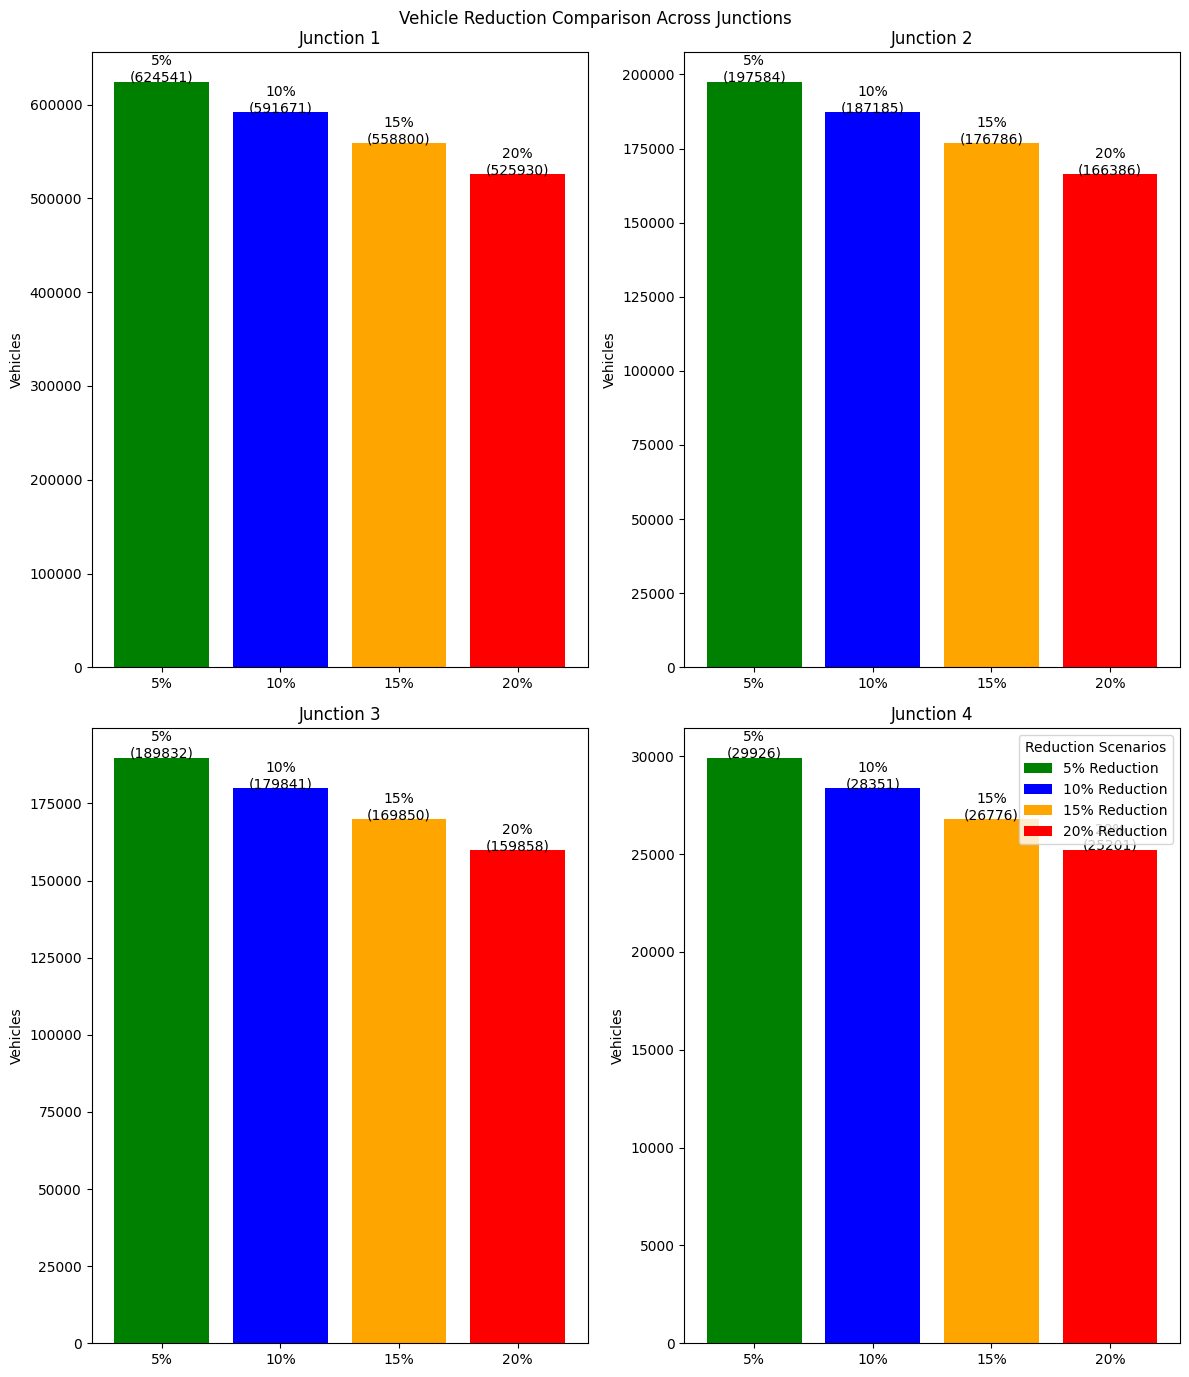

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 14)) # Creating 2*2 subplots for 4 junctions
junctions = junction_data['Junction'].unique()
reduction_colors = ['green', 'blue', 'orange', 'red']
for i, junction in enumerate(junctions):
  ax = axs[i // 2, i % 2] # Accessing Subplot positions
  junction_subset = junction_data[junction_data['Junction'] == junction]
  bar_positions = np.arange(len(reduction_scenarios))

  # Plotting bars for each reduction
  for j, reduction in enumerate(reduction_scenarios):
    ax.bar(bar_positions[j], junction_subset[f'Vehicles_Reduced_{int(reduction*100)}'].values[0], color=reduction_colors[j],
           label=f'{int(reduction*100)}% Reduction')
    # Adding percentage label on top of each bar
    ax.text(bar_positions[j],
                junction_subset[f'Vehicles_Reduced_{int(reduction*100)}'].values[0] + 10,
                f'{int(reduction*100)}%\n({junction_subset[f"Vehicles_Reduced_{int(reduction*100)}"].values[0]:.0f})',
                ha='center')
  ax.set_title(f'Junction {junction}')
  ax.set_xticks(bar_positions)
  ax.set_xticklabels([f'{int(red*100)}%' for red in reduction_scenarios])
  ax.set_ylabel('Vehicles')
plt.suptitle('Vehicle Reduction Comparison Across Junctions')
plt.tight_layout()
plt.legend(title='Reduction Scenarios')
plt.show()

1. Separate Subplots: Each subplot shows a single junction with all reduction
   levels (5%, 10%, 15%, and 20%) compared. This makes it easy to compare traffic reduction scenarios at individual junctions.
2. Annotations on Bars: Each bar has a label with the reduction percentage and
   the number of vehicles after the reduction.
3. Color Coding: Each reduction scenario is color-coded for easy comparison
   across the subplots.

# CO2 Reduction plot

In [26]:
import plotly.graph_objects as go
# Simulated reduction data (in tons, related to vehicle reduction)
# Assuming each vehicle emits 0.2 tons of CO2 per journey and we have the same reduction percentages
# Creating new columns for CO2 reduction scenarios based on vehicle reduction percentage
reduction_scenarios = [0.05, 0.1, 0.15, 0.2]
junction_data = df.groupby('Junction')['Vehicles'].sum().reset_index()
for reduction in reduction_scenarios:
  junction_data[f'CO2_Reduced_{int(reduction*100)}'] = junction_data['Vehicles'] * 0.2 * reduction
# Creating an interactive line plot
fig = go.Figure()

# Add traces for reduction in each scenario
for reduction in reduction_scenarios:
  fig.add_trace(go.Scatter(
      x=junction_data['Junction'],
      y=junction_data[f'CO2_Reduced_{int(reduction*100)}'],
      mode='lines+markers',
      name=f'{int(reduction*100)}% CO2 Reduction',
      hoverinfo='text',
      text=junction_data[f'CO2_Reduced_{int(reduction*100)}'].apply(lambda x: f'{x:.2f} tons CO2'),
  ))
# Customizing the layout
fig.update_layout(
    title='Interactive CO2 Reduction Comparison',
    xaxis_title='Junction',
    yaxis_title='CO2 Reduction (tons)',
    hovermode='x unified',
    template='plotly_dark',
)
fig.show()

<ipython-input-26-625d761efcf6>:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



1. Hover Effect: When you hover over the points, you can see the exact CO2
   reduction for that junction and percentage.
2. Line Traces: Each line represents a different reduction scenario (5%, 10%,
   etc.).
3. Interactive Legends: You can toggle visibility of different scenarios by
   interacting with the legend.

# Tree Plantation Needs

In [29]:
# Assuming 1 tree absorbs 0.05 tons of CO2 per year
tree_absorption_per_year = 0.05

# Creating new columns for the numbers of trees needed for each reduction scenario
for reduction in reduction_scenarios:
  junction_data[f'Trees_Needed_{int(reduction*100)}'] = (junction_data[f'CO2_Reduced_{int(reduction*100)}']/tree_absorption_per_year).round()

# Creating a bar plot to visualize the number of trees needed for each scenario
fig_tree = go.Figure()

# Adding traces for reduction scenario
for reduction in reduction_scenarios:
  fig_tree.add_trace(go.Bar(
      x=junction_data['Junction'],
      y=junction_data[f'Trees_Needed_{int(reduction*100)}'],
      name=f'Tree needed for {int(reduction*100)}% Reduction',
      hoverinfo = 'text',
      text=junction_data[f'Trees_Needed_{int(reduction*100)}'].apply(lambda x: f'{x:.0f} trees'),
  ))
# Customizing layout
fig_tree.update_layout(
    title = 'Number of Trees Needed to Offset CO2 Emmissions by Junction',
    xaxis_title = 'Junction',
    yaxis_title = 'Number of Trees',
    barmode = 'stack',
    hovermode = 'x unified',
    template = 'plotly_dark',
)
fig_tree.show()

1. Bar Plot: Each bar shows the number of trees required to offset the CO2
   reduction at a specific junction.
2. Hover Labels: The exact number of trees needed is shown when hovering over
   each bar.
3. Interactive: You can toggle between the reduction scenarios to view the
   impact on tree needs for different percentages (5%, 10%, etc.).

# Combining both Visualizations in one Dash Board

In [30]:
! pip install dash
! pip install dash-core-components
! pip install dash-html-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.1 MB/s eta 0:00:00


In [32]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

# Initializing the dash app
app = dash.Dash(__name__)

# Layout of the dashboard
app.layout = html.Div([ # Changed to html.Div()
    html.H1("Traffic optimization Impact Analysis"),
    html.Div([
        html.H3("CO2 Reduction Scenario by Junction"),
        dcc.Graph(id='co2-reduction-plot', figure=fig),
    ]),
    html.Div([
        html.H3("Tree Plantations Needs to offset CO2 Emissions"),
        dcc.Graph(id='tree-plantation-plot', figure=fig_tree),
    ]),
])
# Running the App
if __name__ == '__main__':
  app.run_server(debug=True)

<IPython.core.display.Javascript object>